porownanie globalne, animcaja od lat ok 60, zrobienie algorytmu ktory sprawdza nagle spadki (srednia rkoczaca czy cos) ktory wyrzuca nagle anomalie (bezwzgl wartosci pkb). potem sprawdzic co wtedy bylo

podzial na zwykjle i percapita

algorytm wykrywajacy anomalie

uwzglednienie podzialu na kategorie kraju

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches
import imageio.v2 as imageio
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Wczytanie gpd <br>
bez kolumn indicator name i indicator code informujące o przedstawianiu pkb przy pomocy dolarów  (GDP per capita (current US$)	i NY.GDP.PCAP.CD)<br>
drop 2024 ponieważ są tam same Nan

In [3]:
gdp = pd.read_excel('gdp.xls', sheet_name='Data', skiprows=3)
gdp = gdp.drop(columns=['Indicator Name', 'Indicator Code','2024'])


In [4]:
gdp_per_capita = pd.read_excel('gdp_per_capita.xls', sheet_name='Data', skiprows=3)
gdp_per_capita = gdp_per_capita.drop(columns=['Indicator Name', 'Indicator Code','2024'])

Informacje o tym do jakiej grupy przychodowej zakategoryzowano dane kraje

In [5]:
metadata = pd.read_excel('gdp.xls', sheet_name='Metadata - Countries')
metadata = metadata[['Country Code','IncomeGroup','Region']]

Join metadanych do kolumn 

In [6]:
data = pd.merge(gdp, metadata, on='Country Code', how='left')

In [7]:
data_pc = pd.merge(gdp_per_capita, metadata, on='Country Code', how='left')

https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

In [8]:
world1 = gpd.read_file("shape/ne_110m_admin_0_countries.shp")
world1 = world1[['ADMIN','SOV_A3','geometry']]
world1 = world1.rename(columns={'ADMIN': 'Country Name', 'SOV_A3': 'Country Code'})

"https://github.com/datasets/geo-countries/raw/main/data/countries.geojson"

In [9]:
world2 = gpd.read_file("https://github.com/datasets/geo-countries/raw/main/data/countries.geojson")
world2 = world2[['name','ISO3166-1-Alpha-3','geometry']]
world2 = world2.rename(columns={'name': 'Country Name', 'ISO3166-1-Alpha-3': 'Country Code'})
world2 = world2[world2['Country Code'] != '-99']

Z istotnych krajów Brakuje Francji

https://github.com/georgique/world-geojson/blob/develop/countries/france.json

In [10]:
franceshp = gpd.read_file("shape/france.json")
franceshp = franceshp.dissolve()
franceshp = franceshp.to_crs(world2.crs)
franceshp['Country Code'] = 'FRA'
france_row = franceshp[['Country Code', 'geometry']]
france_row = france_row.reset_index(drop=True)

world2 = pd.concat([world2, france_row], ignore_index=True)


In [11]:
world = pd.concat([world1, world2]).drop_duplicates(subset='Country Code').reset_index(drop=True)
world = world[['Country Code','geometry']]

In [12]:
data = pd.merge(world, data, on='Country Code', how='left')
data_pc = pd.merge(world, data_pc, on='Country Code', how='left')

In [13]:
data.head(3)

,Country Code,geometry,Country Name,1960,1961,1962,1963,1964,1965,1966,...,2016,2017,2018,2019,2020,2021,2022,2023,IncomeGroup,Region
0,FJI,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...",Fiji,1.123284e+08,1.169878e+08,1.229064e+08,1.294547e+08,1.400327e+08,1.470848e+08,1.506039e+08,...,4.930214e+09,5.353469e+09,5.581425e+09,5.444407e+09,4.432466e+09,4.305032e+09,4.969504e+09,5.442047e+09,Upper middle income,East Asia & Pacific
1,TZA,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...",Tanzania,2.651730e+09,2.826179e+09,3.101590e+09,3.456579e+09,3.748841e+09,3.817227e+09,4.377999e+09,...,4.977441e+10,5.327488e+10,5.700371e+10,6.102673e+10,6.606874e+10,7.065563e+10,7.576997e+10,7.906240e+10,Lower middle income,Sub-Saharan Africa
2,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data_pc.head(3)

,Country Code,geometry,Country Name,1960,1961,1962,1963,1964,1965,1966,...,2016,2017,2018,2019,2020,2021,2022,2023,IncomeGroup,Region
0,FJI,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...",Fiji,277.431535,280.273367,285.473073,291.383574,305.532203,311.241073,309.574409,...,5363.790256,5826.848141,6085.419792,5950.828686,4844.421290,4696.171019,5405.030074,5888.736686,Upper middle income,East Asia & Pacific
1,TZA,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...",Tanzania,275.296021,285.156799,303.997437,329.010590,346.301819,342.077942,380.497925,...,953.010742,986.674011,1023.106262,1063.322510,1117.415283,1159.856567,1207.853027,1224.489624,Lower middle income,Sub-Saharan Africa
2,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------------------------------
MAPY
-------------------------------

[]

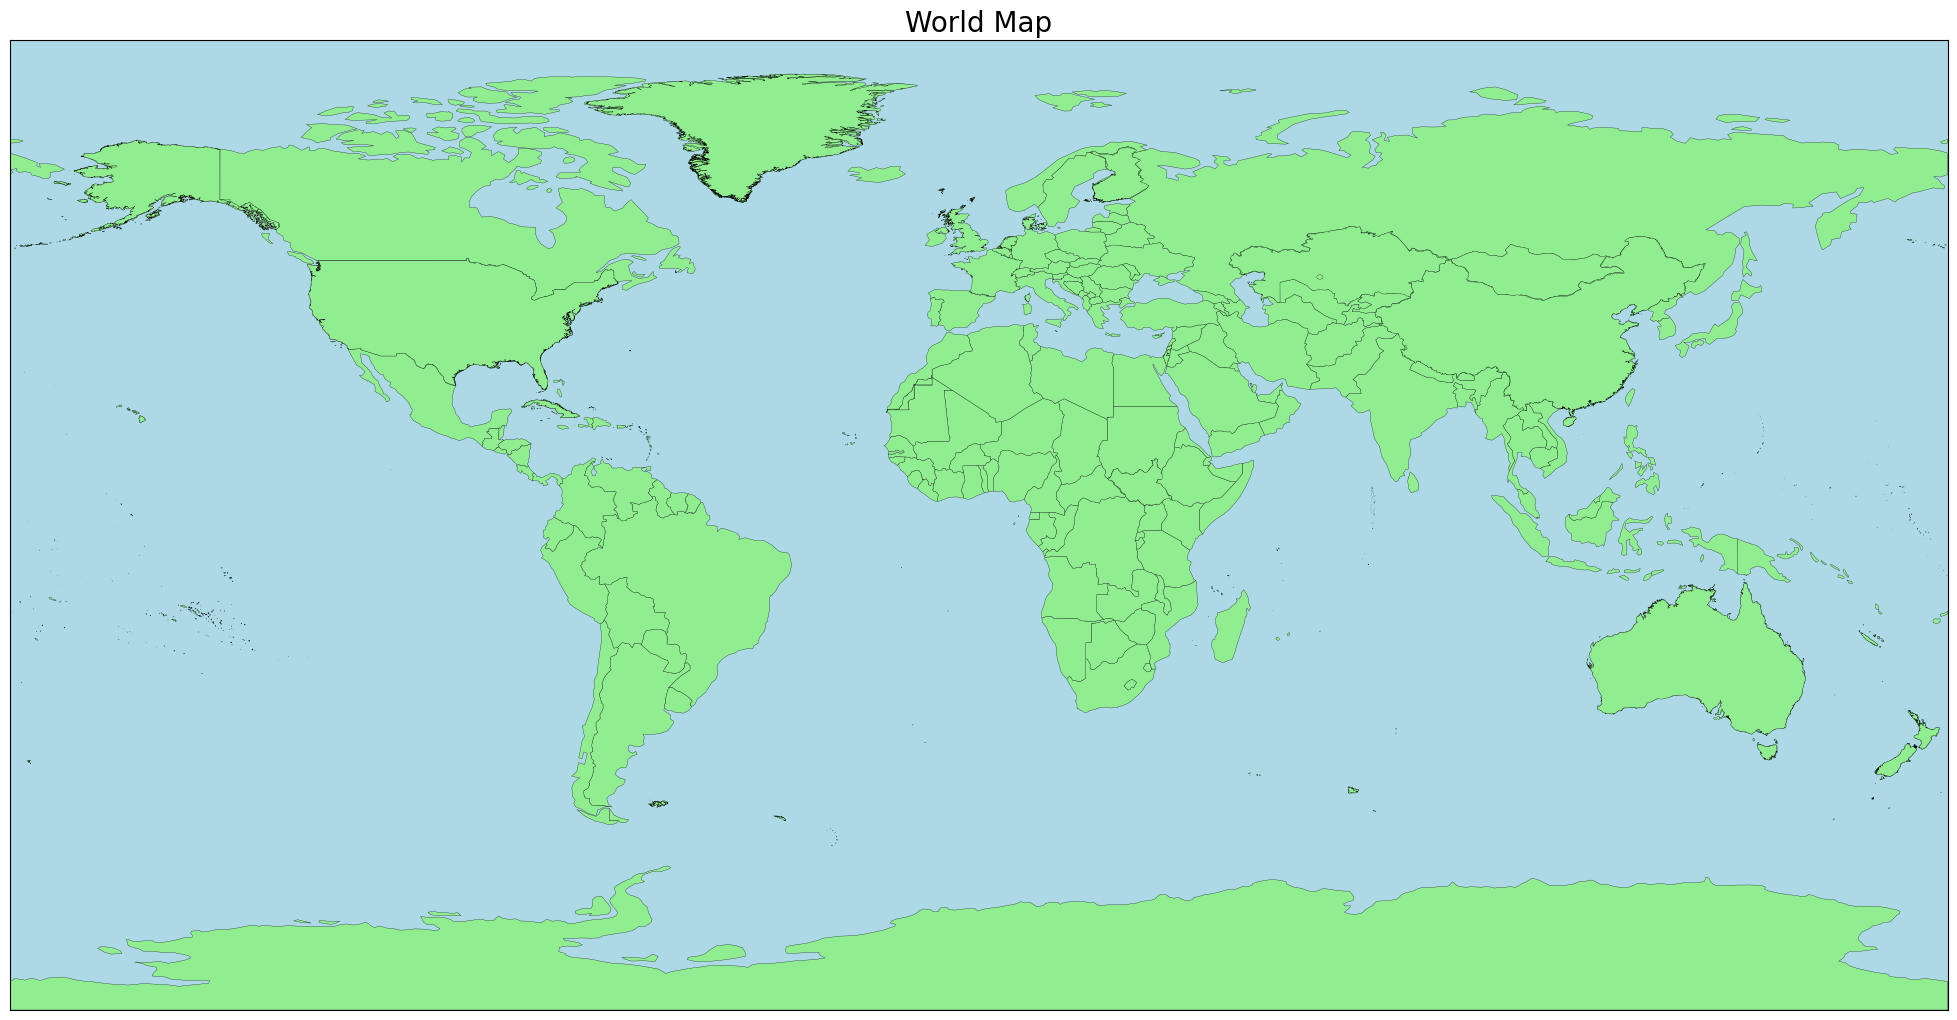

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
data.plot( ax=ax, color='lightgreen',  edgecolor='black', linewidth=0.2)
ax.set_facecolor('lightblue')
ax.set_title('World Map', fontsize=20)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_xticks([])
ax.set_yticks([])

Posiadamy DataFrame Zawierający:<br>
-Kod Kraju<br>
-geometrie na mapie Świata<br>
-Nazwe Kraju<br>
-Dane na temat Pkb od 1960-2023<br>
-Kategorię grupy dochodowej kraju<br>

kolory do plotu income groups

In [16]:
data['IncomeGroup'] = data['IncomeGroup'].fillna('Unknown')
data_pc['IncomeGroup'] = data_pc['IncomeGroup'].fillna('Unknown')

legend_colors = {
    'Low income': 'red',
    'Lower middle income': 'orange',
    'Upper middle income': 'yellow',
    'High income': 'green',
    'Unknown': 'grey'
}
data['color'] = data['IncomeGroup'].map(legend_colors)
data_pc['color'] = data_pc['IncomeGroup'].map(legend_colors)


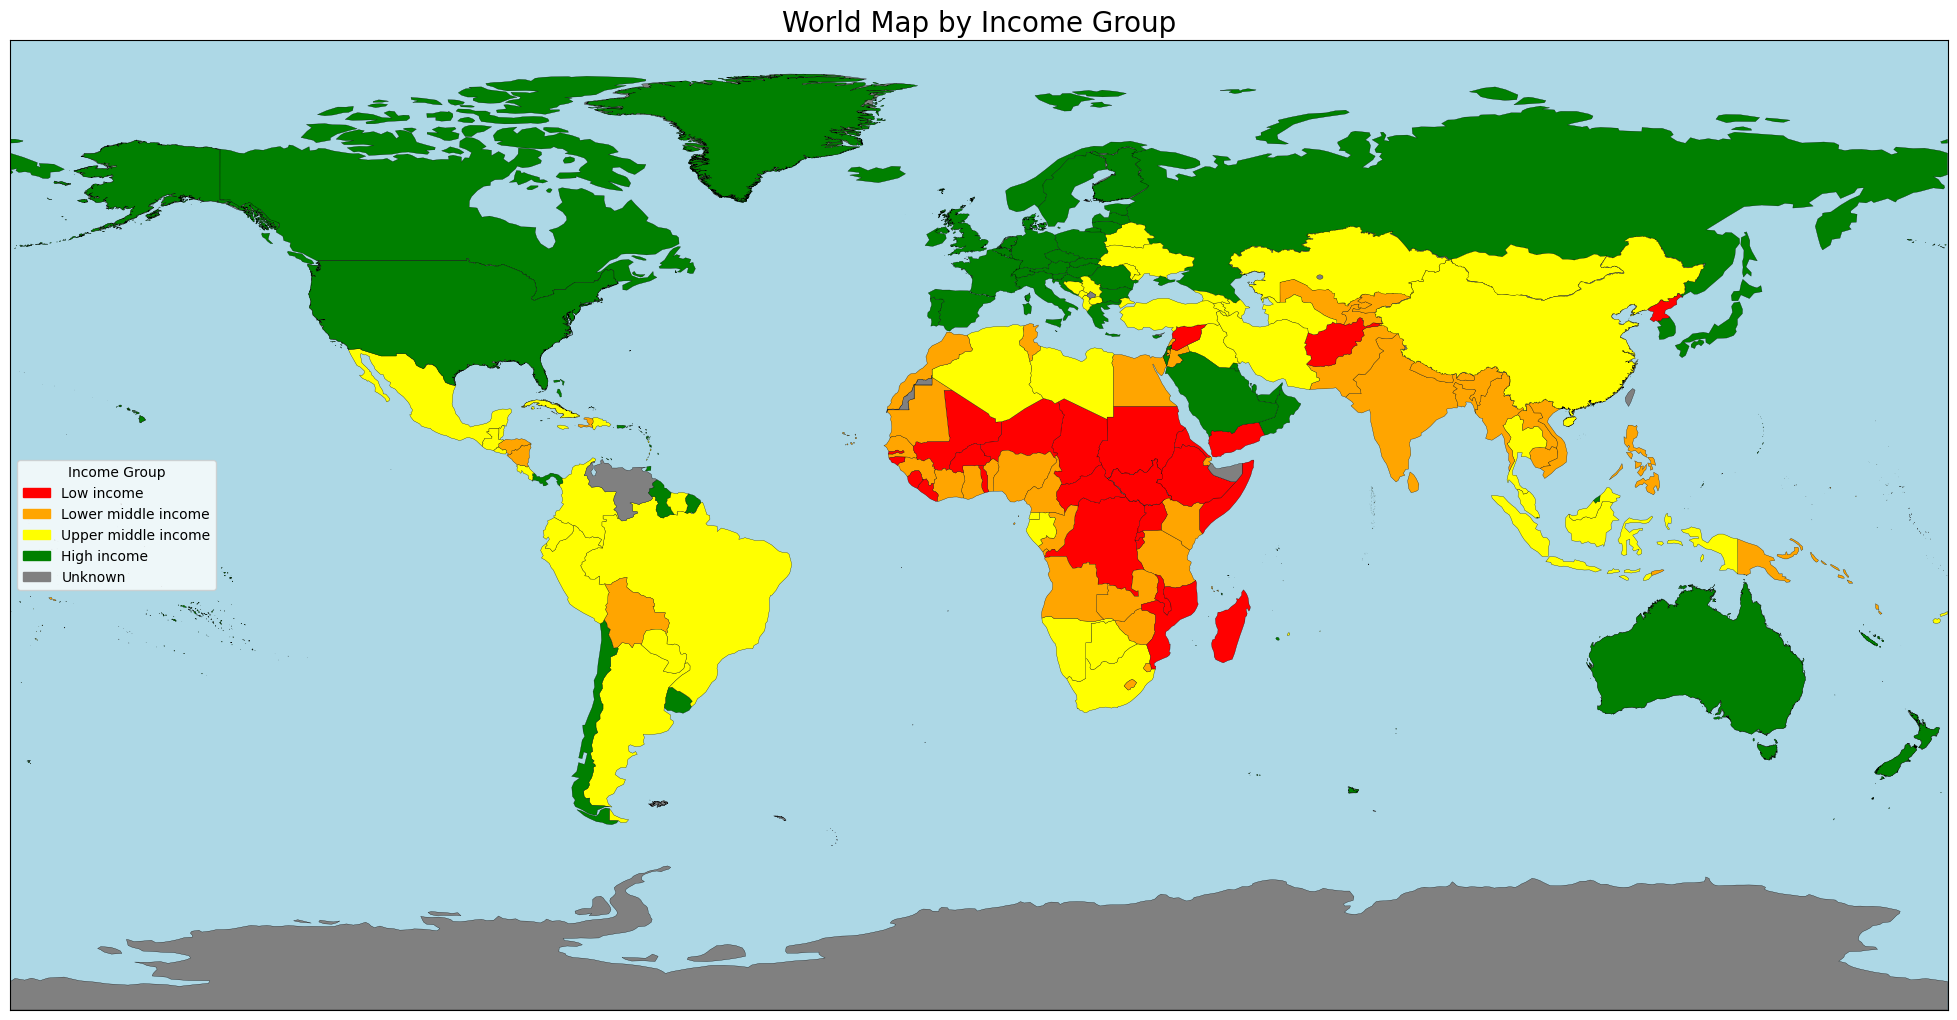

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
data.plot(ax=ax, color=data['color'], edgecolor='black', linewidth=0.2)
ax.set_facecolor('lightblue')
ax.set_title('World Map by Income Group', fontsize=20)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_xticks([])
ax.set_yticks([])


handles = [mpatches.Patch(color=color, label=group) for group, color in legend_colors.items()]
ax.legend(handles=handles, title='Income Group', loc='center left')

Przykładowy wykres dla pkb.<br>
zmieńmy pkb do miliardów

In [18]:
for col in data.columns[3:-3]:
    data[col] = data[col].fillna(0)
    data[col] = data[col] / 1e9  #do miliardów
for col in data_pc.columns[3:-3]:
    data_pc[col] = data_pc[col].fillna(0)


Funkcja przygotowana pod animowanie

In [19]:
def plot_gdp_map(data_source, year='2023',scale="normal"):
  fig, ax = plt.subplots(1, 1, figsize=(25, 15))

  data_source[data_source[year] == 0].plot(ax=ax, color='grey', edgecolor='black', linewidth=0.2)
  if scale=='log':
    title = 'PKB na świecie w roku ' + year + ' (skala logarytmiczna)'
    data_source[data_source[year] != 0].plot(ax=ax, column=year, edgecolor='black', cmap='coolwarm', linewidth=0.2, legend=True,norm=plt.Normalize(vmin=0, vmax=10), legend_kwds={'label': "PKB w skali log10(miliardów USD)",
                                                                                                                                                                                  'shrink':0.6})
  if scale=='pc':
    title = 'PKB per capita na świecie w roku ' + year
    data_source[data_source[year] != 0].plot(ax=ax, column=year, edgecolor='black', cmap='coolwarm', linewidth=0.2, legend=True,norm=plt.Normalize(vmin=0, vmax=85000), legend_kwds={'label': "PKB per capita w USD",
                                                                                                                                                                                  'shrink':0.6})
  if scale=='pc_log':
    title = 'PKB per capita na świecie w roku ' + year + ' (skala logarytmiczna)'
    data_source[data_source[year] != 0].plot(ax=ax, column=year, edgecolor='black', cmap='coolwarm', linewidth=0.2, legend=True,norm=plt.Normalize(vmin=0, vmax=11), legend_kwds={'label': "PKB per capita w USD",
                                                                                                                                                                                  'shrink':0.6})
  if scale=='normal':
    title = 'PKB na świecie w roku ' + year
    data_source[data_source[year] != 0].plot(ax=ax, column=year, edgecolor='black', cmap='coolwarm', linewidth=0.2, legend=True,norm=plt.Normalize(vmin=0, vmax=28000), legend_kwds={'label': "PKB w miliardach USD",'shrink':0.6})
  
  
  ax.set_facecolor('lightblue')
  ax.set_xlim([-180, 180])
  ax.set_ylim([-90, 90])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title, fontsize=20)
  
  return fig, ax

(<Figure size 2500x1500 with 2 Axes>,
 <Axes: title={'center': 'PKB na świecie w roku 2023'}>)

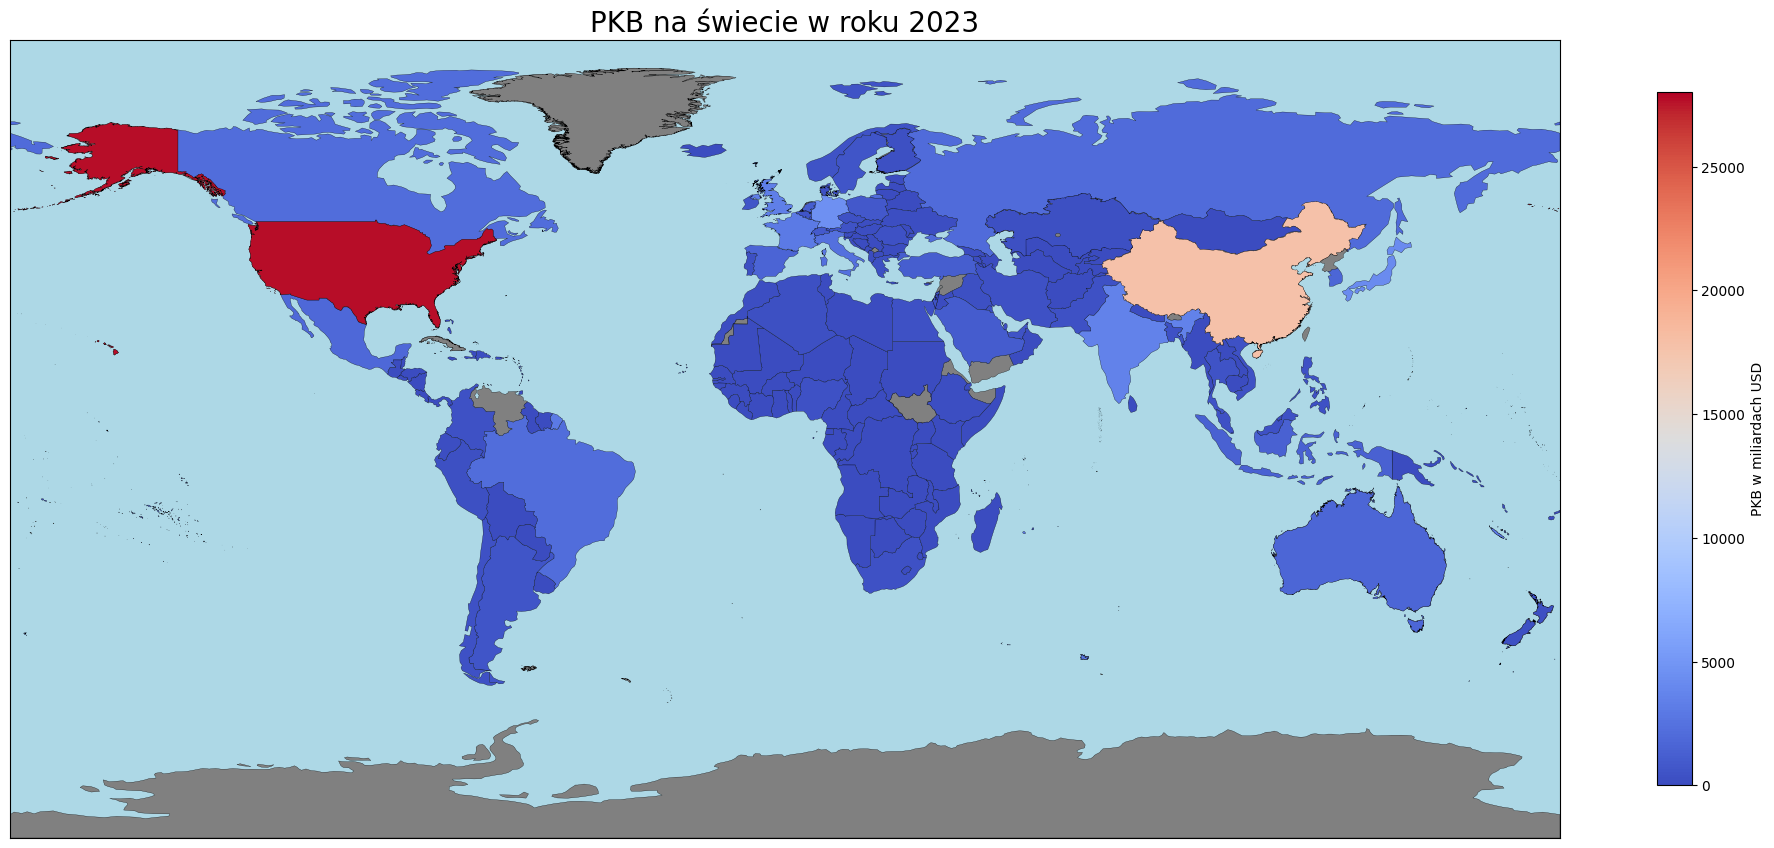

In [20]:
plot_gdp_map(data, '2023')

Widać, że nie jest to najlepsza opcja ze względu na wartości odstające dla najbogatszych krajów.
Spróbujmy skali logarytmicznej

In [21]:
data_log = data.copy()
data_pc_log = data_pc.copy()
for col in data_log.columns[3:-3]:
    data_log[col] = np.log(data_log[col].replace(0, np.nan))
    data_log[col] = data_log[col].fillna(0)
for col in data_pc.columns[3:-3]:
    data_pc_log[col] = np.log(data_pc[col].replace(0, np.nan))
    data_pc_log[col] = data_pc_log[col].fillna(0)



(<Figure size 2500x1500 with 2 Axes>,
 <Axes: title={'center': 'PKB na świecie w roku 2023 (skala logarytmiczna)'}>)

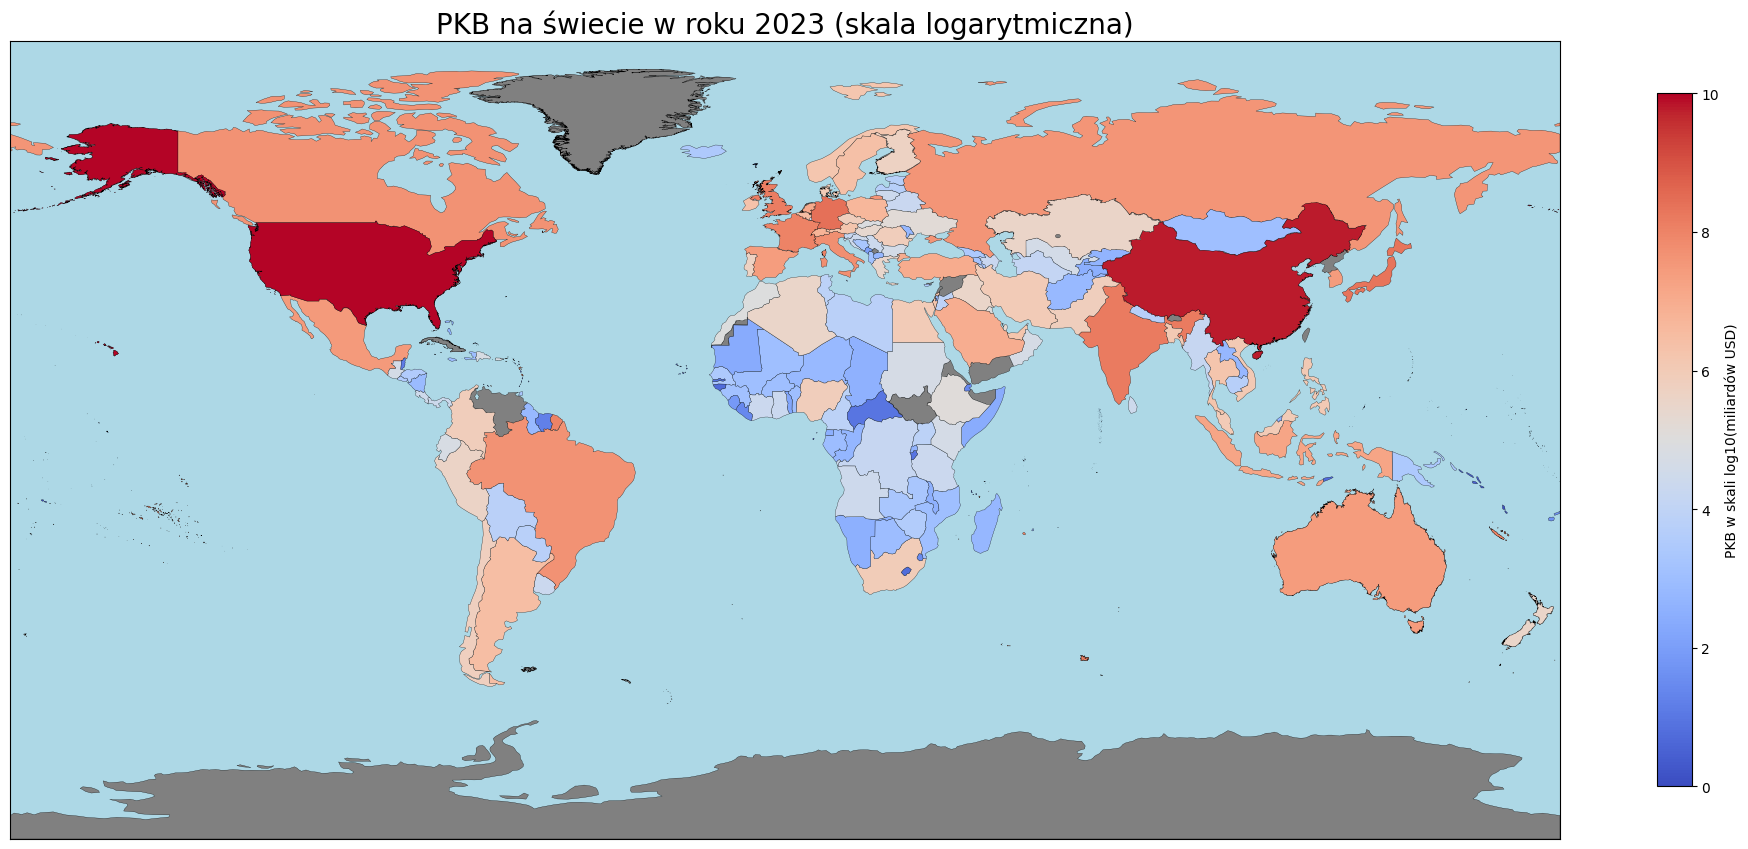

In [22]:
plot_gdp_map(data_log, '2023',scale='log')

In [23]:
def create_map_gif(data_source, years, filename='gdp_map.gif',scale='log'):
  images = []
  for year in years:
    plot_gdp_map(data_source, year=year, scale=scale)
    plt.savefig(f'tmp_{year}.png')
    plt.close()
    images.append(imageio.imread(f'tmp_{year}.png'))

  imageio.mimsave(filename, images, fps = 5,loop=0)

  for year in years:
    os.remove(f'tmp_{year}.png')


In [24]:
years = [str(year) for year in range(1960, 2024)]
create_map_gif(data_log, years,scale='log')


<img src="gdp_map.gif"   />

(<Figure size 2500x1500 with 2 Axes>,
 <Axes: title={'center': 'PKB per capita na świecie w roku 2023'}>)

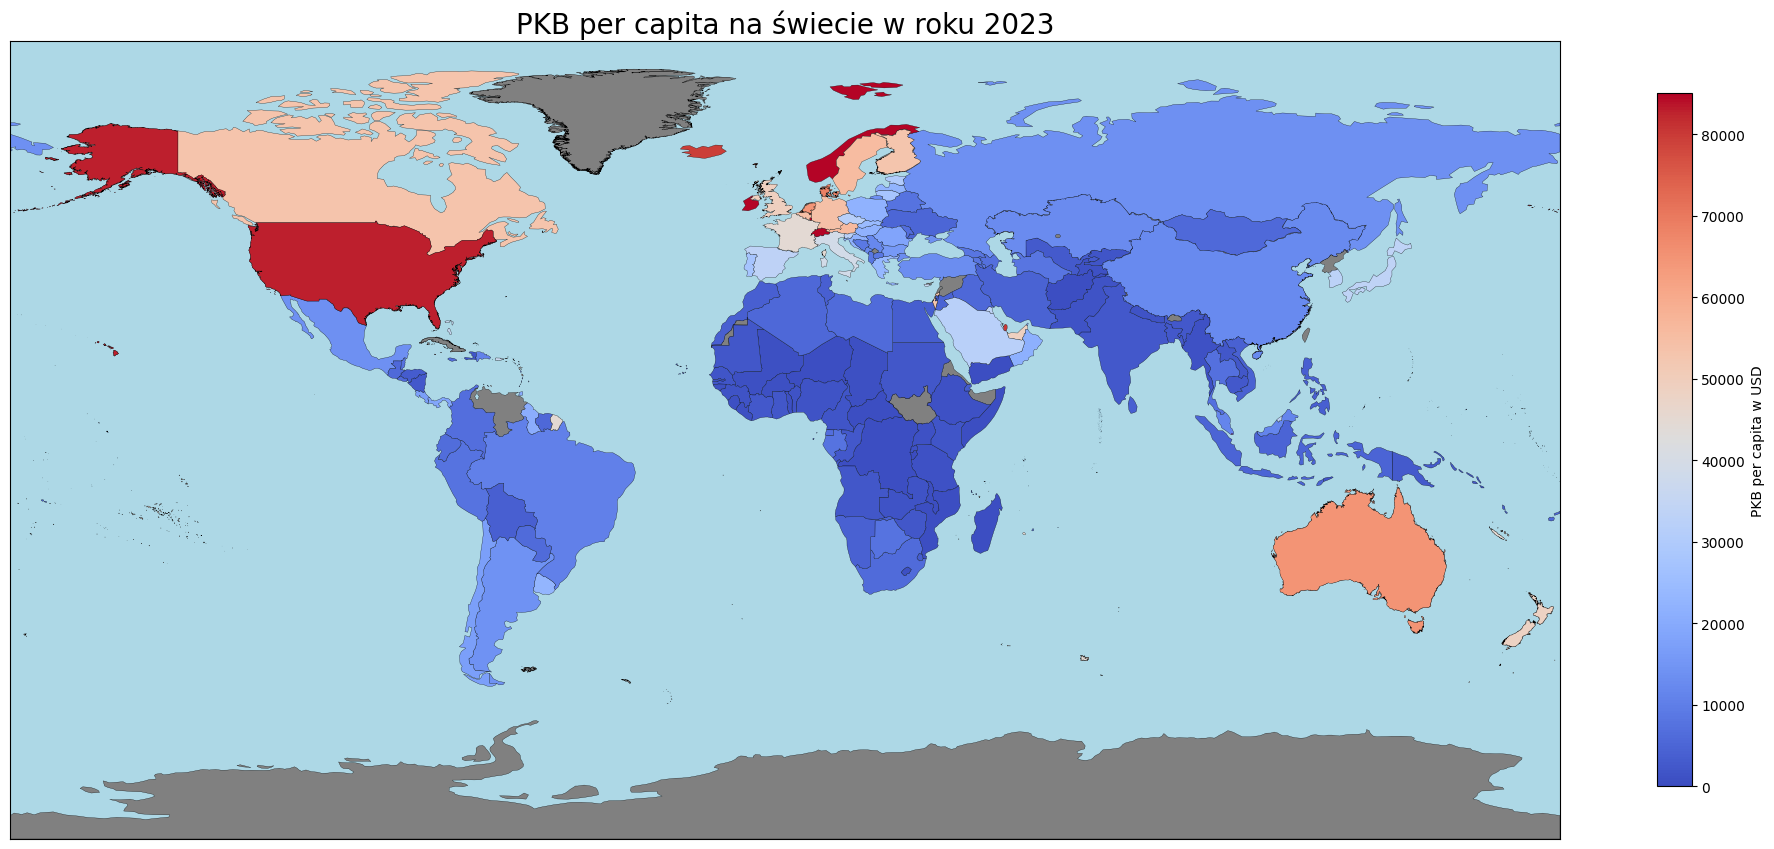

In [25]:
plot_gdp_map(data_pc, '2023', scale='pc')

wytestujmy skalę logarytmiczną i w tym przypadku

(<Figure size 2500x1500 with 2 Axes>,
 <Axes: title={'center': 'PKB per capita na świecie w roku 2023 (skala logarytmiczna)'}>)

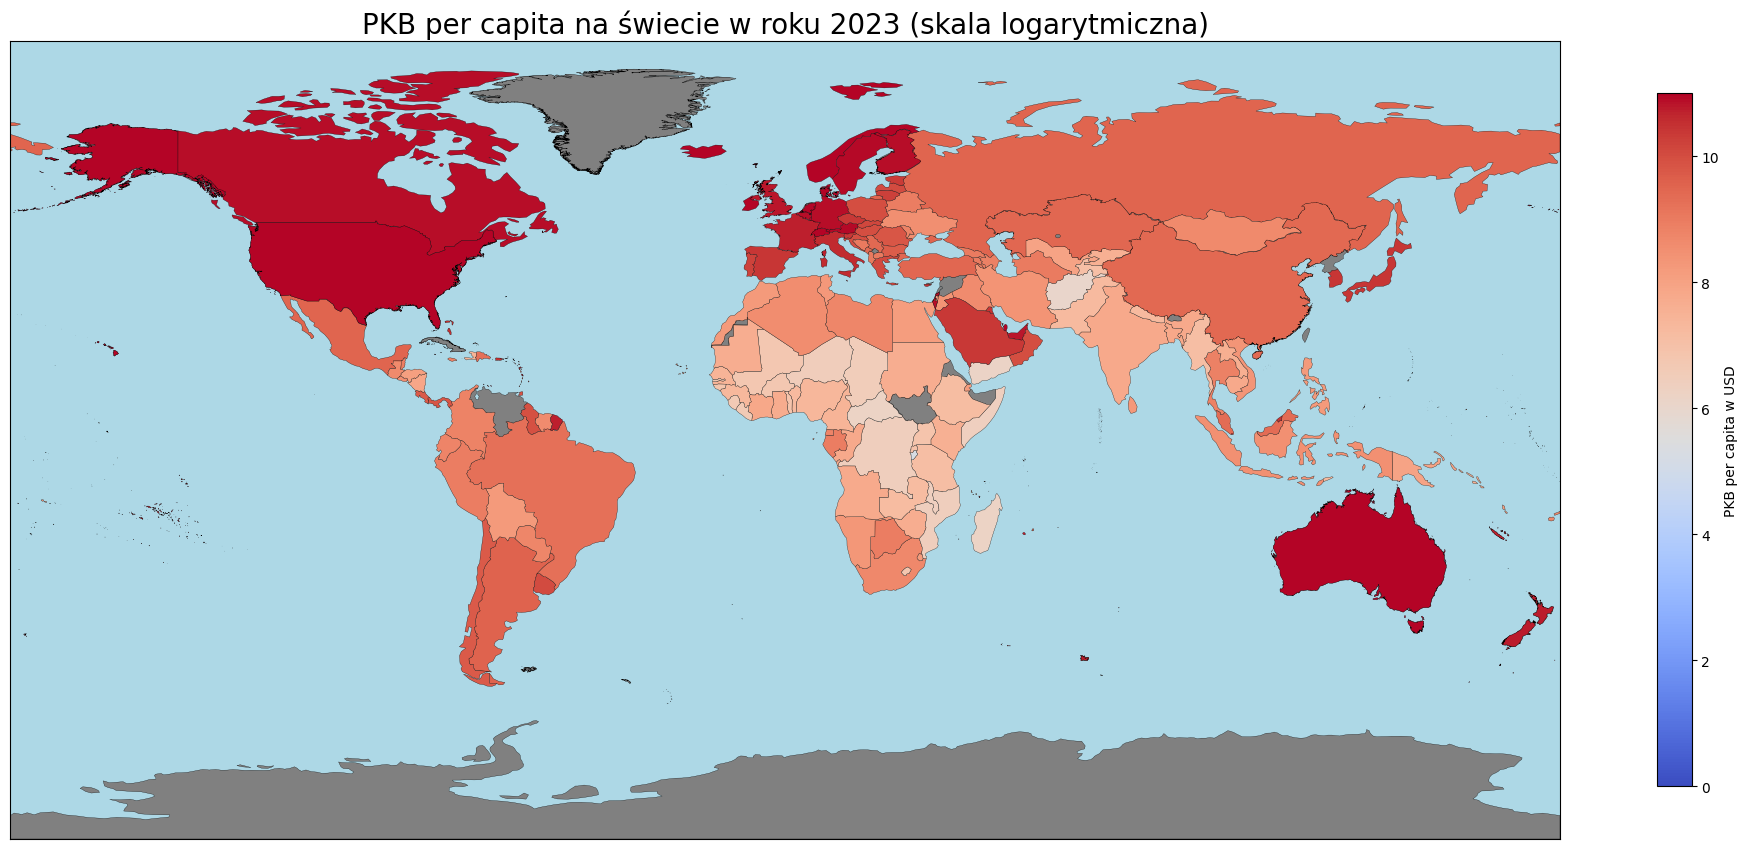

In [26]:
plot_gdp_map(data_pc_log, '2023', scale='pc_log')

sprawdza się ona o wiele gorzej od standardowej

In [27]:
create_map_gif(data_pc, years,scale='pc', filename='gdp_per_capita_map.gif')

<img src='gdp_per_capita_map.gif'/>

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PRACA Z WYKRESAMI
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
population = data.copy()
for col in population.columns[3:-3]:
    population[col] = population[col] * 100000000/ data_pc[col]

In [29]:
def circle_plot( data_source, year='2023', ylim=(0, 30000),legend_colors=legend_colors,population_df=population,scale='normal'):
  income_order=['Unknown', 'Low income', 'Lower middle income', 'Upper middle income', 'High income']
  data_sorted = data_source.copy()
  data_sorted['IncomeGroup'] = pd.Categorical(data_sorted['IncomeGroup'], categories=income_order, ordered=True)
  data_sorted = data_sorted.sort_values('IncomeGroup')


  plt.figure(figsize=(9, 9))
  plt.scatter(
    data_sorted['IncomeGroup'],
    data_sorted[year],
    s=population_df.loc[data_sorted.index, year] / 1e4,
    alpha=0.7,
    c=data_sorted['IncomeGroup'].map(legend_colors)
  )

  offsets_high = [(10, 10), (-50, -10), (10, -10), (-50, 10)]
  offsets_other = [(10, 5), (-30, -5)]

  limit = 0
  if scale == 'normal':
    limit = 1000
    title = 'PKB kraju a grupa dochodowa w ' + year
  if scale == 'pc':
    title = 'PKB per capita kraju a grupa dochodowa w ' + year
    limit = 70000

  for i, row in data_sorted.iterrows():
    if row[year] > limit:
      if row['IncomeGroup'] == 'High income':
        offset = offsets_high[i % 4]
      else:
        offset = offsets_other[i % 2]
      plt.annotate(
        row['Country Name'],
        (row['IncomeGroup'], row[year]),
        fontsize=7,
        alpha=0.7,
        xytext=offset,
        textcoords='offset points',
      )

  plt.xlabel('Income Group')
  plt.ylabel('GDP (Billion USD)')
  plt.title(title, fontsize=14)
  plt.xticks(ticks=range(len(income_order)), labels=income_order, rotation=20)
  plt.ylim(ylim)
  plt.xlim(-0.5, len(income_order) - 0.5)
  plt.grid(True, linestyle='--', alpha=0.3)
  #plt.show()

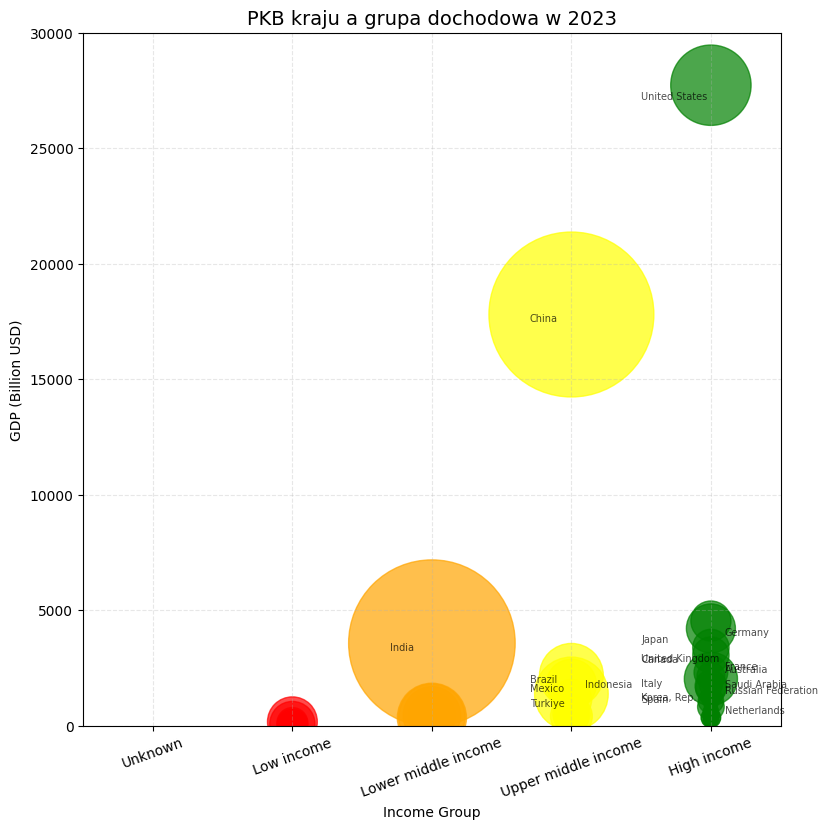

In [30]:
circle_plot( data, year='2023', ylim=(0, 30000), scale='normal')

In [31]:
def create_gif(data_source, years, filename='gdp_vs_income_group.gif', ylim=(0, 30000), legend_colors=legend_colors, population_df=population,scale='normal'):
  images = []
  for year in years:
    circle_plot(data_source, year=year, ylim=ylim, legend_colors=legend_colors, population_df=population_df,scale=scale)
    plt.savefig(f'tmp_{year}.png')
    plt.close()
    images.append(imageio.imread(f'tmp_{year}.png'))

  imageio.mimsave(filename, images, fps = 5 ,loop=0)

  for year in years:
    os.remove(f'tmp_{year}.png')


In [32]:
create_gif(data, years=years,scale='normal')

<img src="gdp_vs_income_group.gif"/>

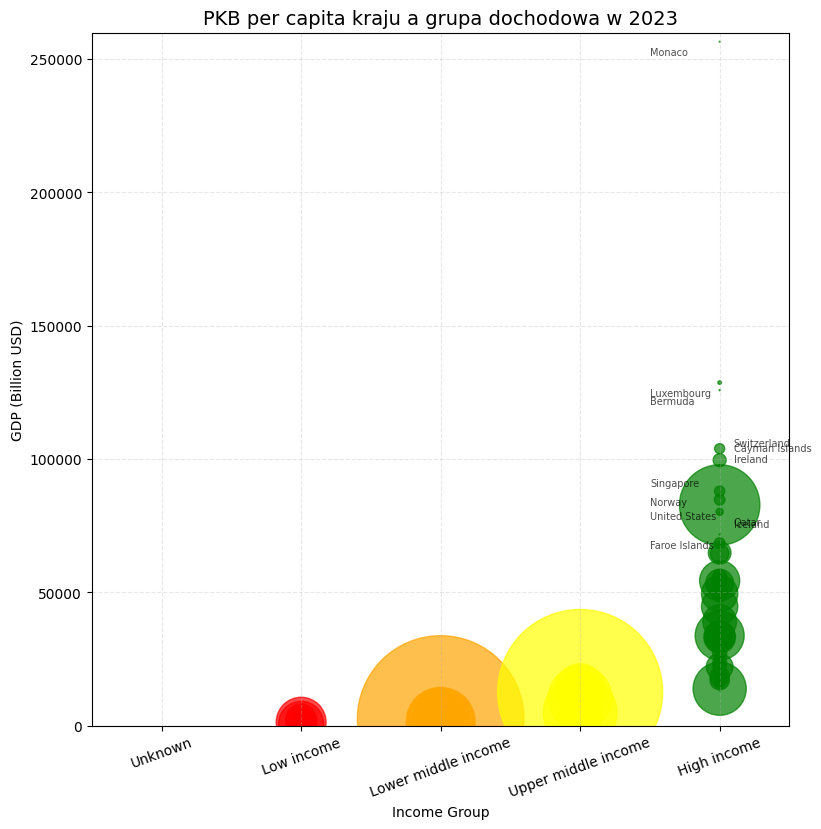

In [33]:
circle_plot(data_pc, year='2023', ylim=(0, 260000),scale='pc')


In [34]:
create_gif(data_pc, years=years,scale='pc', filename='gdp_per_capita_vs_income_group.gif', ylim=(0, 260000))

<img src = "gdp_per_capita_vs_income_group.gif" />

-----------------------------------------------------------------------------------------------------------------------------------------------------------
Algorytm wykrywający nagłe zmiany
------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
#algorytm wykrywający anomalie

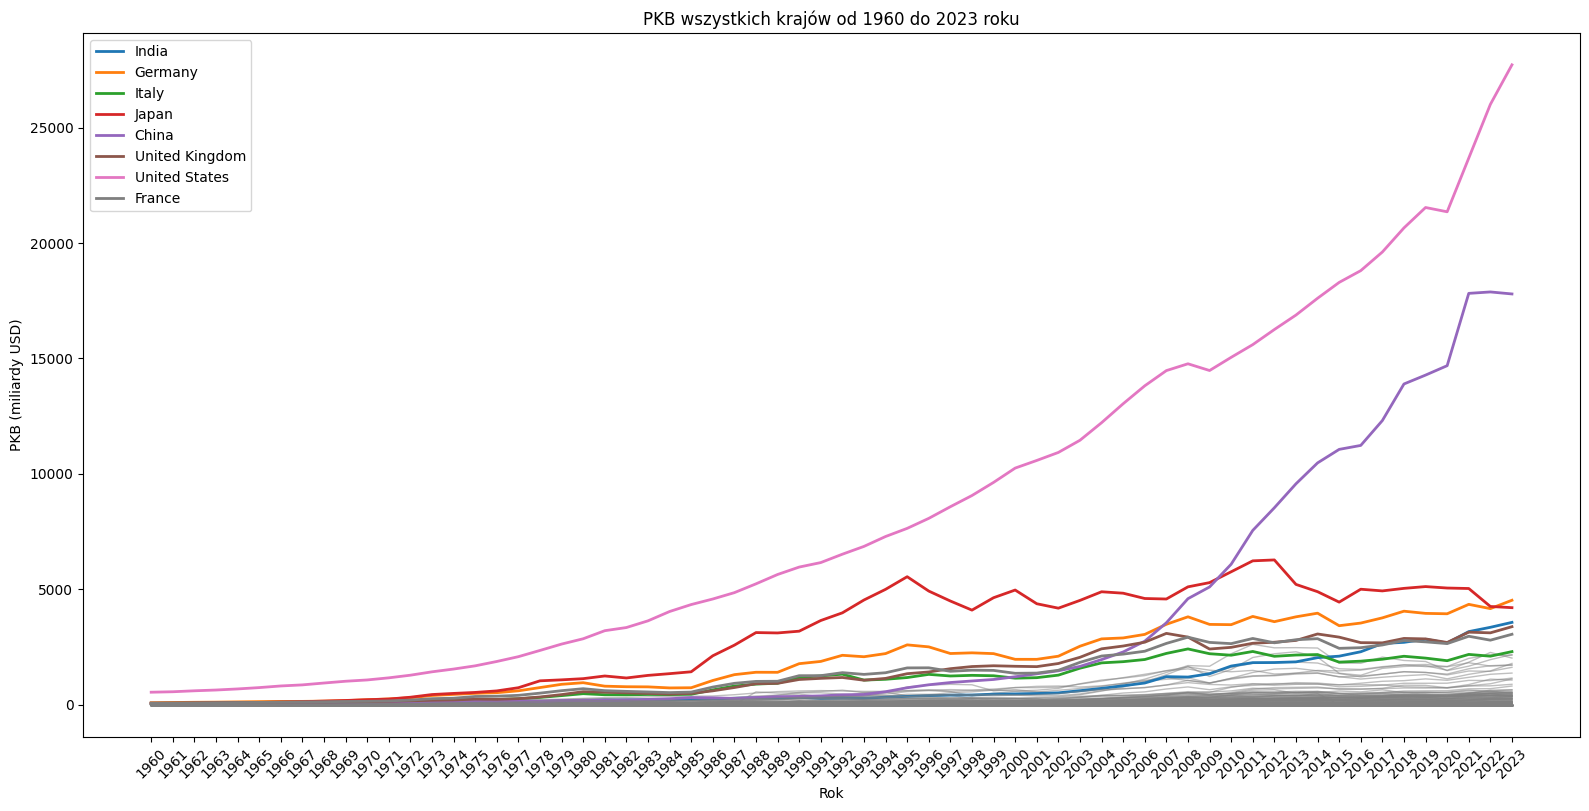

In [38]:
top10 = data.nlargest(8, '2023')
plt.figure(figsize=(16, 8))

for i, row in data.iterrows():
  if row['Country Name'] in top10['Country Name'].values:
    plt.plot(data.columns[3:-3], row[data.columns[3:-3]], label=row['Country Name'], linewidth=2)
  else:
    plt.plot(data.columns[3:-3], row[data.columns[3:-3]], color='grey', alpha=0.5, linewidth=1)

plt.legend()
plt.xlabel('Rok')
plt.ylabel('PKB (miliardy USD)')
plt.title('PKB wszystkich krajów od 1960 do 2023 roku')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

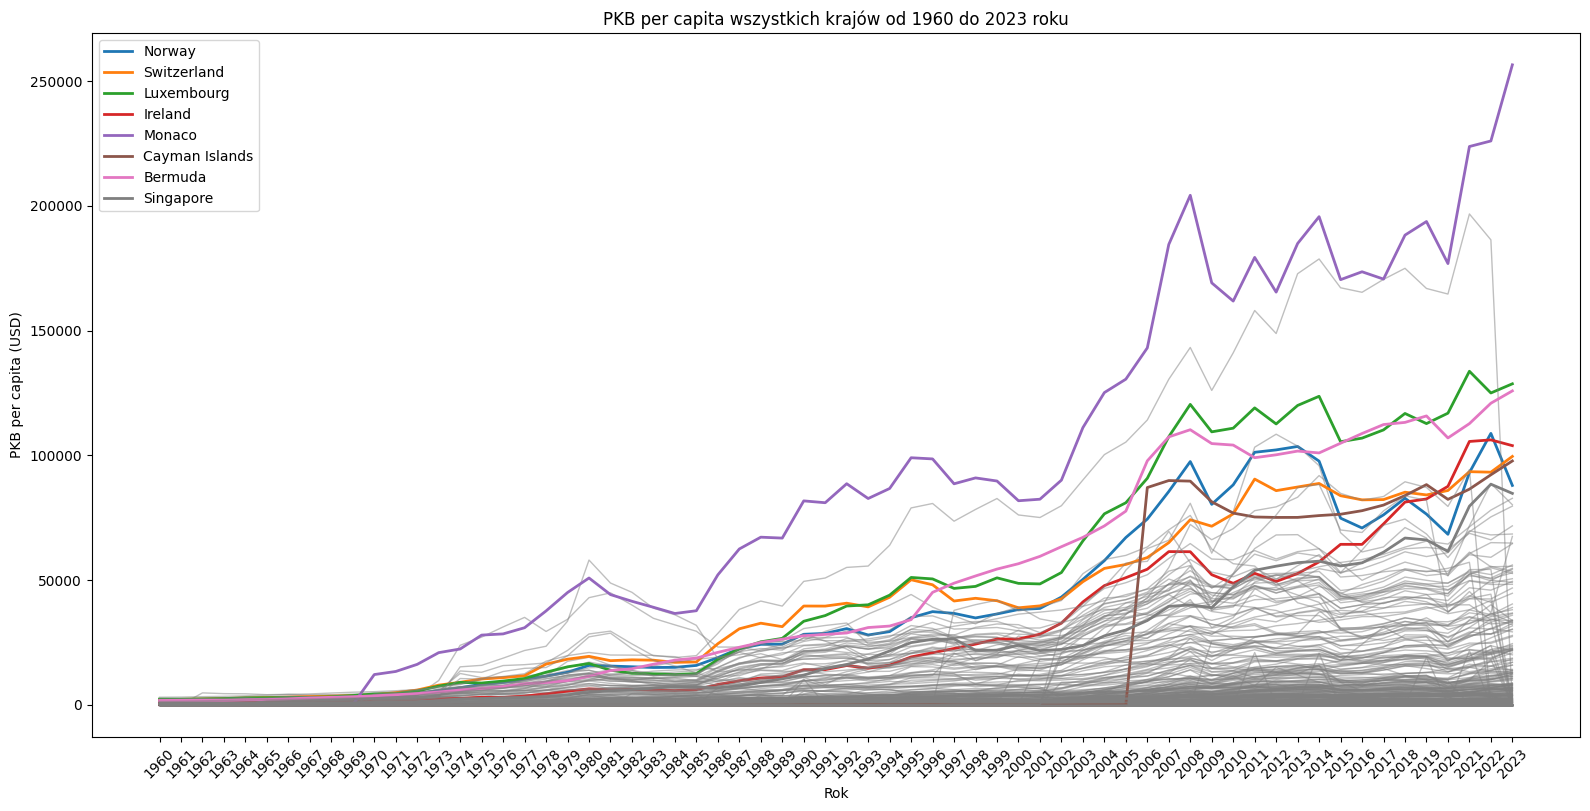

In [43]:
top10 = data_pc.nlargest(8, '2023')
plt.figure(figsize=(16, 8))

for i, row in data_pc.iterrows():
  if row['Country Name'] in top10['Country Name'].values:
    plt.plot(data_pc.columns[3:-3], row[data_pc.columns[3:-3]], label=row['Country Name'], linewidth=2)
  else:
    plt.plot(data_pc.columns[3:-3], row[data_pc.columns[3:-3]], color='grey', alpha=0.5, linewidth=1)

plt.legend()
plt.xlabel('Rok')
plt.ylabel('PKB per capita (USD)')
plt.title('PKB per capita wszystkich krajów od 1960 do 2023 roku')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()